# Notebook 01: MLForecast Model Evaluation and Advanced Feature Engineering

In this notebook, I continue refining my forecasting approach by creating the MLForecast_Evaluator class to assess models. I also implement advanced feature engineering techniques and test the performance of XGBoost and CatBoost models.  

# Imports:

In [3]:
# Standard library imports
import math
import random
from datetime import date
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import (MinMaxScaler, RobustScaler, FunctionTransformer, 
                                   OneHotEncoder, TargetEncoder, StandardScaler)
import category_encoders as ce
from catboost import CatBoostRegressor
import catboost as cb
from xgboost import XGBRegressor

# MLforecast related imports
from mlforecast import MLForecast

from mlforecast.target_transforms import Differences, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExponentiallyWeightedMean, ExpandingMean, ExpandingStd
import optuna

# Other forecasting utilities
from window_ops.rolling import rolling_mean, rolling_std
from window_ops.shift import shift_array

# Performance optimization
from numba import njit
from functools import partial

# Suppress warnings
warnings.filterwarnings('ignore')

# Local imports
from ml_forecast_evaluator import MLForecast_Evaluator

# Helper functions

In [4]:
def query_unique_id(df, unique_id=None, target_col='y'):
    """Filters a DataFrame by unique_id (or a random one) and plots the resulting time series."""

    unique_id = unique_id or random.sample(list(df['unique_id']), 1)[0]
    query_df = df[df['unique_id'] == unique_id]

    if not query_df.empty:
        sns.lineplot(data=query_df, x='ds', y=target_col)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"No data found for unique_id: {unique_id}")

    return query_df

# Data Load:

In [3]:
# data = pd.read_pickle('./data/imputed_data_15f.pkl')
data = pd.read_pickle('./data/KNN_imputed_data_15f.pkl')

In [4]:
STATIC_FEATURES = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# Feature engineering:

## Manual ordinal encoding.

There are some top items, categories, etc. I encode them as top1, 2nd, 3rd.

In [5]:
def create_ordinal_encoded_column(df, category_col, measure_col, agg_func, top1=0, top2=0):
    # Group by the specified category and aggregate the measure column
    grouped_df = df.groupby(category_col)[measure_col].agg(agg_func).sort_values(ascending=False)
    
    # Calculate the count for top3
    top3 = len(grouped_df) - top1 - top2

    # Get the top N values for encoding
    top1_values = grouped_df.head(top1).index.tolist() if top1 > 0 else []
    top2_values = grouped_df.head(top1 + top2).tail(top2).index.tolist() if top2 > 0 else []
    top3_values = grouped_df.tail(top3).index.tolist() if top3 > 0 else []

    # Create a new ordinal encoded column
    df[f'{category_col}_{measure_col}_ordinal_encoded'] = df[category_col].apply(
        lambda x: 3 if x in top1_values else 2 if x in top2_values else 1 if x in top3_values else 0
    )

    return df

In [6]:
data = create_ordinal_encoded_column(data, 'item_category_id', 'revenue', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'item_category_id', 'y', 'sum', top1=3, top2=0)
data = create_ordinal_encoded_column(data, 'item_id', 'y', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'item_id', 'revenue', 'sum', top1=2, top2=4)
data = create_ordinal_encoded_column(data, 'shop_id', 'revenue', 'sum', top1=1, top2=4)
data = create_ordinal_encoded_column(data, 'shop_id', 'y', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'city_id', 'y', 'sum', top1=1, top2=0)
data.sample(5)

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,...,month_sin,month_cos,revenue,item_category_id_revenue_ordinal_encoded,item_category_id_y_ordinal_encoded,item_id_y_ordinal_encoded,item_id_revenue_ordinal_encoded,shop_id_revenue_ordinal_encoded,shop_id_y_ordinal_encoded,city_id_y_ordinal_encoded
11157,799.0,2.0,2015-04-30,52_16167,18,52,64,16167,4,2015,...,8.660254e-01,-5.000000e-01,1598.0,1,1,1,1,1,1,1
2544,500.0,4.0,2015-04-30,22_18016,7,22,49,18016,4,2015,...,8.660254e-01,-5.000000e-01,2000.0,1,1,1,1,1,1,3
9590,399.0,2.0,2015-09-30,42_12134,14,42,30,12134,9,2015,...,-1.000000e+00,-1.836970e-16,798.0,1,3,1,1,1,1,1
6492,177.0,7.0,2013-12-31,31_17717,7,31,79,17717,12,2013,...,-2.449294e-16,1.000000e+00,1239.0,1,1,1,2,3,3,3
9418,5.0,30.0,2014-10-31,42_20949,14,42,71,20949,10,2014,...,-8.660254e-01,5.000000e-01,150.0,1,3,3,1,1,1,1


## Grouping features and interactions:

In [7]:
def build_ts_features(df, cols_to_group, target_column, lags, aggfunc):

    assert "ds" in df.columns.tolist(), "Date must be in df columns"

    # Error control for lags
    if not isinstance(lags, list):
        raise ValueError("Lags should be a list of integers.")
    
    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group + [target_column] + [aggfunc.__name__])

    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.set_index("ds")
        .groupby(cols_to_group)
        .resample("ME")[target_column]
        .agg(aggfunc)
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # Generate lag and diff features for specified lags
    for n in lags:
               grouped_df[f'{new_name}_lag{n}'] = grouped_df.groupby(cols_to_group)[new_name].shift(n)
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    grouped_df.drop(new_name, inplace = True, axis = 1)

    # Merge the generated features back into the original DataFrame
    merge_cols = ['ds'] + cols_to_group
    df = pd.merge(df, grouped_df, on=merge_cols, how='left')

    return df

In [8]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['y', 'revenue']
groups = [
    ['item_id'],
    ['shop_id'],
    ['item_category_id'],
    ['item_id', 'city_id'],
    ['shop_id', 'item_category_id'],
    ['item_category_id', 'city_id'],
]
agg_functions = [np.sum, np.max, np.min]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = build_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                    lags=[1,2],
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 22)


Dropping columns that might cause target leakage item_id_y_sum
Dropping columns that might cause target leakage item_id_y_max
Dropping columns that might cause target leakage item_id_y_min
Dropping columns that might cause target leakage shop_id_y_sum
Dropping columns that might cause target leakage shop_id_y_max
Dropping columns that might cause target leakage shop_id_y_min
Dropping columns that might cause target leakage item_category_id_y_sum
Dropping columns that might cause target leakage item_category_id_y_max
Dropping columns that might cause target leakage item_category_id_y_min
Dropping columns that might cause target leakage item_id_city_id_y_sum
Dropping columns that might cause target leakage item_id_city_id_y_max
Dropping columns that might cause target leakage item_id_city_id_y_min
Dropping columns that might cause target leakage shop_id_item_category_id_y_sum
Dropping columns that might cause target leakage shop_id_item_category_id_y_max
Dropping columns that might cause

In [9]:
print(f"Initial DataFrame shape: {data.shape}")

agg_functions = [np.sum, np.max, np.min]

for agg_func in agg_functions:
    data = build_ts_features(
                            df=data,
                            cols_to_group=['city_id'],
                            target_column='revenue',
                            aggfunc=agg_func,
                            lags=[1,2],
                        )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 94)
Dropping columns that might cause target leakage city_id_revenue_sum
Dropping columns that might cause target leakage city_id_revenue_max
Dropping columns that might cause target leakage city_id_revenue_min
Final DataFrame shape: (14484, 100)


#### Build features without resampling: Useful for timely analysis. Grouping by month, quarter, year.

In [10]:
def avg_ts_features(df, cols_to_group, target_column, aggfunc):

    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group + [target_column] + [aggfunc.__name__])

    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.groupby(cols_to_group)[target_column]
        .agg(aggfunc)
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # Merge the generated features back into the original DataFrame
    df = pd.merge(df, grouped_df, on=cols_to_group, how='left')

    return df

In [11]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['monthly_average_price', 'revenue']
groups = [
    ['shop_id', 'year'],
    ['item_category_id', 'year'],
    ['item_id', 'quarter'],
    ['shop_id', 'quarter'],
    ['item_category_id', 'quarter'],
    ['city_id', 'quarter'],
]
agg_functions = [np.mean, np.std, np.max, np.min]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 100)
Final DataFrame shape: (14484, 148)


In [12]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['revenue']
groups = [
    ['item_id', 'around_Xmas'],
    ['shop_id', 'around_Xmas'],
    ['item_category_id', 'around_Xmas'],
    ['city_id', 'around_Xmas'],
]
agg_functions = [np.mean]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 148)
Final DataFrame shape: (14484, 152)


In [13]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['revenue']
groups = [
    ['item_id', 'month'],
    ['shop_id', 'month'],
    ['item_category_id', 'month'],
    ['city_id', 'month'],
]
agg_functions = [np.mean]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 152)
Final DataFrame shape: (14484, 156)


In [14]:
data.isnull().sum().to_frame()[data.isnull().sum().to_frame()[0] > 852] #minimun NaNs for lags

,0


## Clusters base in target stats. On train data only:

I commented the lines to include clusters distances as features. They could be incorporated in the dataset.

In [15]:
data_tmf = data.copy()

In [16]:
test_index = [sorted(list(data_tmf["ds"].unique()))[-1]]
cluster_train = data_tmf[~data_tmf['ds'].isin(test_index)]
desc_stats = cluster_train.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])

Fitting data with 2 clusters
Fitting data with 3 clusters
Fitting data with 4 clusters
Fitting data with 5 clusters
Fitting data with 6 clusters
Fitting data with 7 clusters
Fitting data with 8 clusters
Fitting data with 9 clusters
Fitting data with 10 clusters
Fitting data with 11 clusters
Fitting data with 12 clusters
Fitting data with 13 clusters
Fitting data with 14 clusters


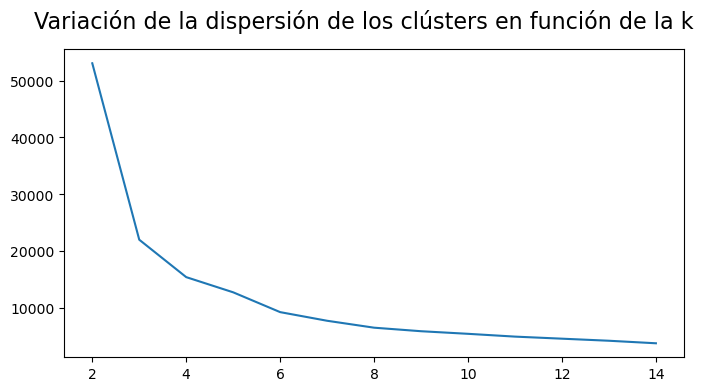

In [17]:
sse = {}

for k in range(2, 15):
    print(f"Fitting data with {k} clusters")
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(desc_stats_for_clustering)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [18]:
# Using 6 clusters:
nr_clusters = 3
kmeans = KMeans(n_clusters=nr_clusters, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_

distances = kmeans.transform(desc_stats_for_clustering)
distances.shape

(426, 3)

In [19]:
clusters_features = pd.DataFrame(distances, columns=[f'cluster_{i}' for i in range(nr_clusters)], 
                                 index=desc_stats.index)

In [20]:
# data_tmf = pd.merge(data_tmf, clusters_features.reset_index(), on='unique_id', how='left')

In [21]:
#merge with full data_tmf
data_tmf = data_tmf.merge(desc_stats[['cluster']], on='unique_id')
data_tmf.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,9.273544,7.506005,0.000000,4.000000,7.000000,13.000000,30.000000
1,3.927868,3.188339,0.000000,2.000000,3.000000,5.000000,23.000000
2,26.980392,7.459039,0.000000,30.000000,30.000000,30.000000,30.000000


## Simple target related transformations

In [22]:
data_tmf['ytd_sales'] = data_tmf.groupby(['unique_id', 'year'])['y'].cumsum()
data_tmf['quarterly_sales'] = data_tmf.groupby(['unique_id', 'quarter'])['y'].cumsum()

In [23]:
data_tmf['price_change'] = data_tmf.groupby('unique_id')['monthly_average_price'].diff()

In [24]:
data_tmf = data_tmf.groupby("unique_id", group_keys=False).apply(lambda df: df.bfill().ffill())

## Dropping self-explicative or unnecessary columns:

**Drop columns**

In [25]:
cols_to_drop = ['revenue', 'month', 'cluster']
data_tmf.drop(cols_to_drop, axis=1, inplace=True)

# Save full features data:

In [26]:
data_tmf.shape

(14484, 157)

In [27]:
data_tmf.to_pickle('./data/full_features_data_157f.pkl')

# Train, Validation, Test Split & Future dataset creation:

Future_df incorporates all exogenous dynamic features and is passed before prediction.

In [5]:
data_tmf = pd.read_pickle('./data/full_features_data_157f.pkl')

In [6]:
train_index = sorted(list(data_tmf["ds"].unique()))[:-2]
valid_index = [sorted(list(data_tmf["ds"].unique()))[-2]]
test_index = [sorted(list(data_tmf["ds"].unique()))[-1]]

In [7]:
train = data_tmf.loc[data_tmf['ds'].isin(train_index)]
valid = data_tmf.loc[data_tmf['ds'].isin(valid_index)]
test = data_tmf.loc[data_tmf['ds'].isin(test_index)]

## Target encoding of shop, item, city, category before fitting:

In [ ]:
data_tmf[STATIC_FEATURES] = data_tmf[STATIC_FEATURES].astype('category')

In [ ]:
# Initialize Targetce2
ce2 = ce.TargetEncoder(cols=STATIC_FEATURES)

# Fit and transform the training train
train_encode = ce2.fit_transform(train[STATIC_FEATURES], train['y'])

valid_encode = ce2.transform(valid[STATIC_FEATURES])
test_encode = ce2.transform(test[STATIC_FEATURES])

train = pd.merge(train.drop(STATIC_FEATURES, axis=1), train_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))
valid = pd.merge(valid.drop(STATIC_FEATURES, axis=1), valid_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))
test = pd.merge(test.drop(STATIC_FEATURES, axis=1), test_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))

In [ ]:
# train.to_csv('./data/train.csv', index=False)
# valid.to_csv('./data/valid.csv', index=False)
# test.to_csv('./data/test.csv', index=False)

In [ ]:
print(train.shape)

(13632, 157)


## Defining "future_df" for MLforecast prediction:

In [ ]:
future_df = pd.concat([valid, test]).drop('y', axis=1)
print(future_df.shape)

(852, 156)


# MLforecast model creation:

## Models

In [ ]:
# Define models with built-in feature selection and regularization

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,          # Limit tree depth to prevent overfitting
    colsample_bytree=0.8, # Feature selection: use 80% of features per tree
    subsample=0.8,        # Use 80% of samples per tree, adding regularization
    reg_lambda=1,         # L2 regularization
    random_state=42
)

cb = CatBoostRegressor(
    iterations=200,        # Number of trees to grow
    learning_rate=0.1,     # Learning rate
    depth=7,               # Maximum depth of trees
    loss_function='RMSE',  # Loss function to optimize
    eval_metric='RMSE',    # Evaluation metric
    random_state=42,        # Random seed for reproducibility
    silent=True
)

models = [xgb, cb]

## Target lags and transformations:

In [ ]:
@njit
def diff_over_previous(x, offset=1):
    """Computes the difference between the current value and its `offset` lag"""
    return x - shift_array(x, offset=offset)

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq='M',
    lags=[1,2],
    lag_transforms={
        1: [
            (rolling_mean, 3),
            (rolling_std, 3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.5),
            ExpandingStd(),
            diff_over_previous, (diff_over_previous, 2)
        ],
        2: [
            (rolling_mean, 3),
            (rolling_std, 3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.5), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            diff_over_previous, (diff_over_previous, 2)
        ],
    },
    # target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],

    num_threads=6
)

### Save full transformed data:

In [ ]:
# full_fe_data = pd.concat([train, valid, test])
# full_fe_data.to_pickle('./data/full_features_data_157f.pkl')

In [ ]:
# transform_data = fcst.preprocess(full_fe_data, dropna=False, static_features=[])
# transform_data.to_pickle('./data/transformed_full_features_data_157f_logdiff.pkl')

# Features Correlation Analysis:

In [ ]:
corr_matrix = fcst.preprocess(train, dropna=False, static_features=[]).corr()
stacked_corr = corr_matrix.stack().reset_index()

# Rename the columns for better readability
stacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#Filter out self-correlations
filtered_corr = stacked_corr[stacked_corr['Feature 1'] != stacked_corr['Feature 2']]

filtered_corr.sort_values(by='Correlation', ascending=False).head(10)

,Feature 1,Feature 2,Correlation
29225,expanding_mean_lag2,expanding_mean_lag1,0.990726
28021,expanding_mean_lag1,expanding_mean_lag2,0.990726
17064,item_category_id_year_monthly_average_price_mean,item_category_id_quarter_monthly_average_price...,0.982515
19128,item_category_id_quarter_monthly_average_price...,item_category_id_year_monthly_average_price_mean,0.982515
28185,exponentially_weighted_mean_lag1_alpha0.5,rolling_mean_lag1_window_size3,0.981477
27669,rolling_mean_lag1_window_size3,exponentially_weighted_mean_lag1_alpha0.5,0.981477
28887,rolling_mean_lag2_window_size3,exponentially_weighted_mean_lag2_alpha0.5,0.981402
29403,exponentially_weighted_mean_lag2_alpha0.5,rolling_mean_lag2_window_size3,0.981402
2785,item_id_y_sum_lag1,item_id_y_sum_lag2,0.978389
2957,item_id_y_sum_lag2,item_id_y_sum_lag1,0.978389


In [ ]:
corr_matrix = fcst.preprocess(train, dropna=False, static_features=[]).corr()
stacked_corr = corr_matrix.stack().reset_index()

# Rename the columns for better readability
stacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#Filter out self-correlations
filtered_corr = stacked_corr[stacked_corr['Feature 1'] == 'y']

filtered_corr.sort_values(by='Correlation', ascending=False).head(10)

,Feature 1,Feature 2,Correlation
174,y,y,1.000000
335,y,exponentially_weighted_mean_lag1_alpha0.5,0.736684
332,y,rolling_mean_lag1_window_size3,0.722743
330,y,lag1,0.689149
342,y,exponentially_weighted_mean_lag2_alpha0.5,0.685011
339,y,rolling_mean_lag2_window_size3,0.679604
209,y,item_id_city_id_y_max_lag1,0.677778
334,y,expanding_mean_lag1,0.671062
341,y,expanding_mean_lag2,0.641318
211,y,item_id_city_id_y_min_lag1,0.640286


## Train and fit all models

In [ ]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'rolling_mean_lag1_window_size3', 'rolling_std_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.5', 'expanding_std_lag1', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'rolling_std_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.5', 'expanding_std_lag2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2'], date_features=[], num_threads=6)

# Evaluate on validation set (h=1)

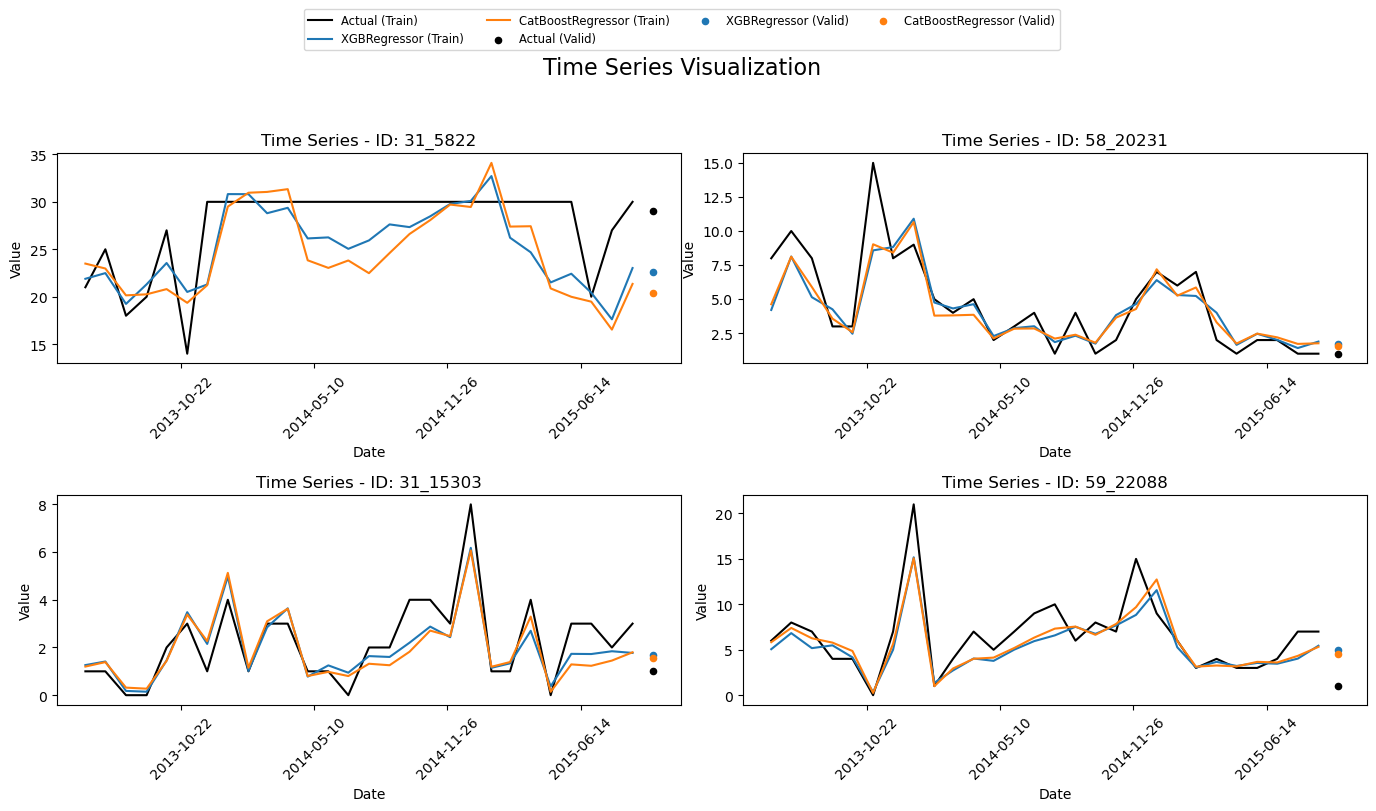

MEAN RMSE_VALID = 2.6266703541244567

Model with lowest RMSE validation is XGBRegressor with RMSE = 2.5962005421427556

                   RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor         2.388063  0.911627    2.596201  0.876177
CatBoostRegressor    2.393999  0.911187    2.657140  0.870295


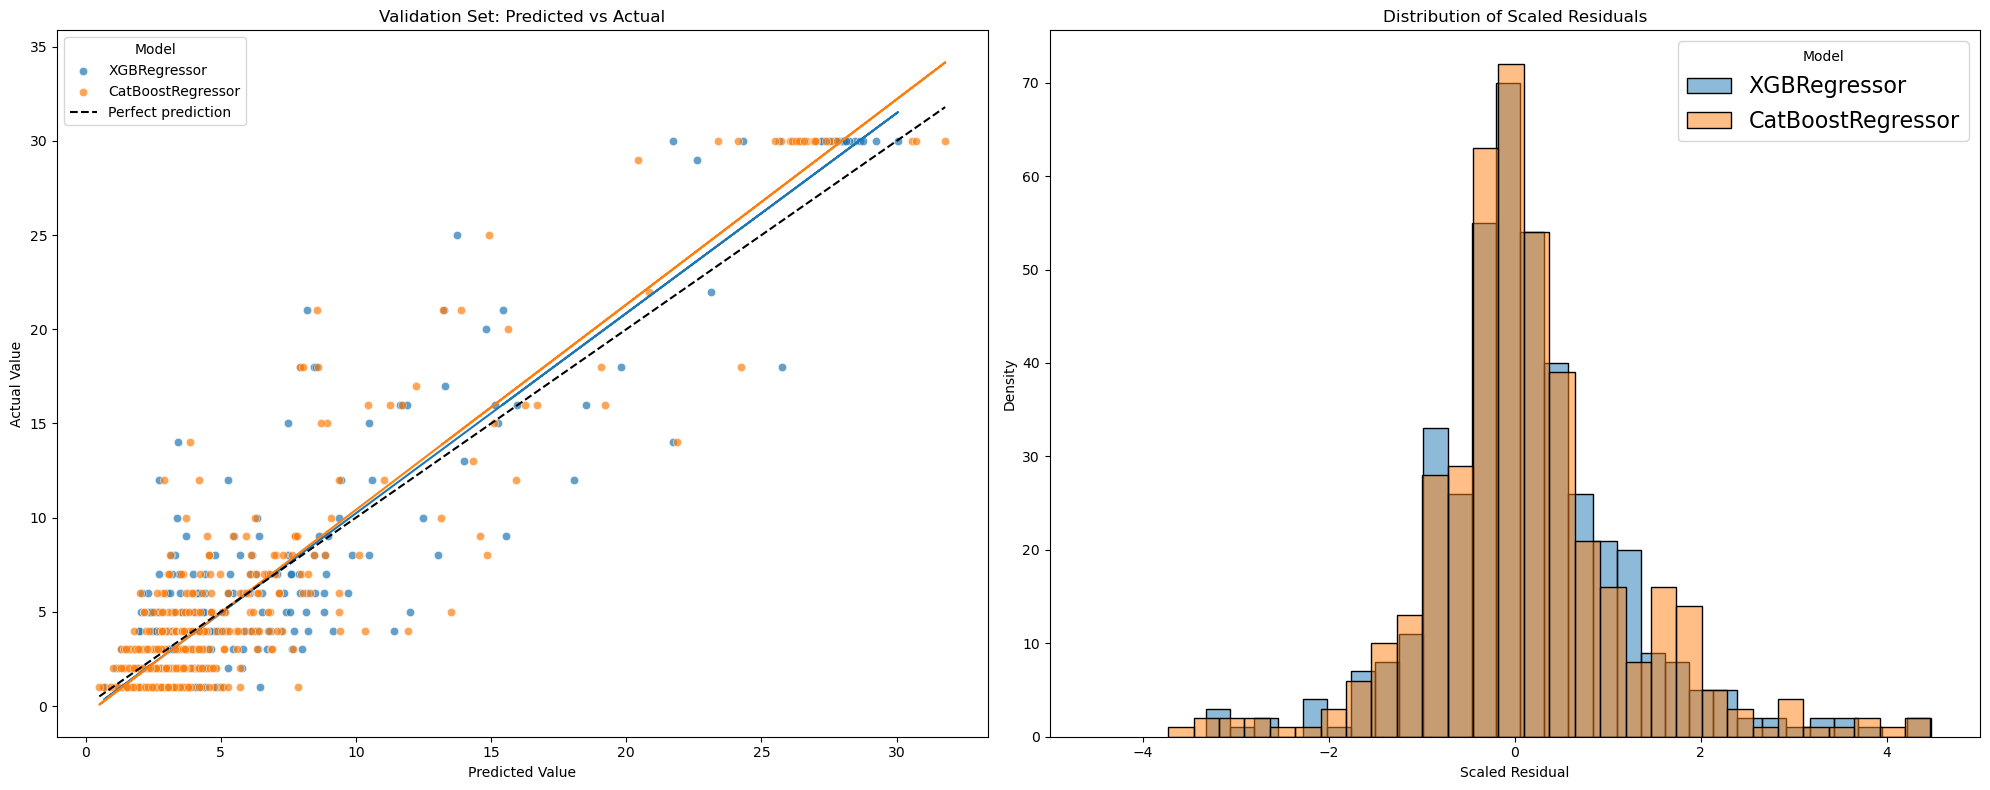

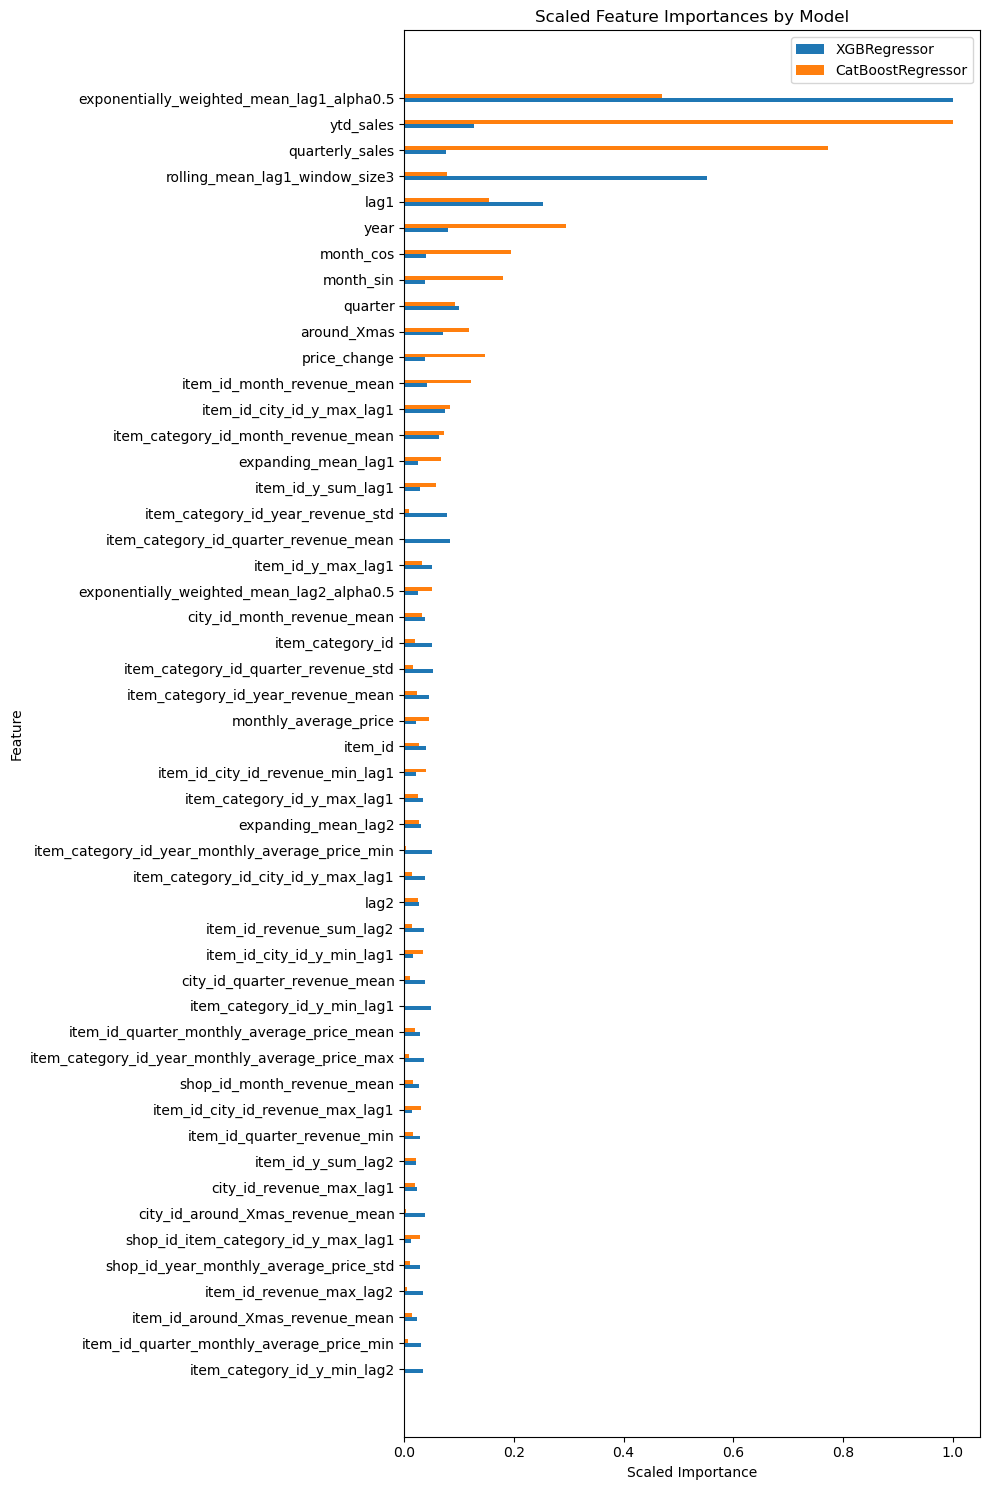

In [ ]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Results

## Target log transformed:

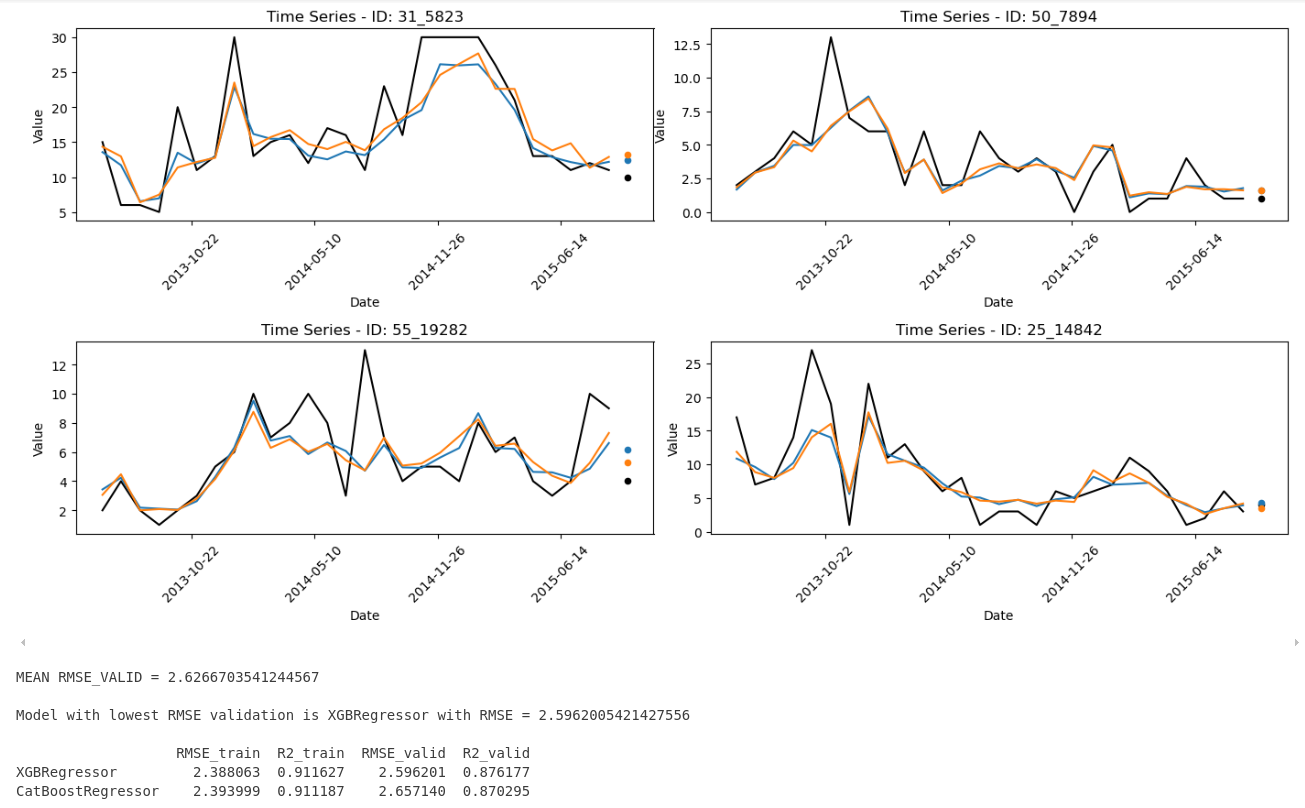

## Target log-diff transformed:

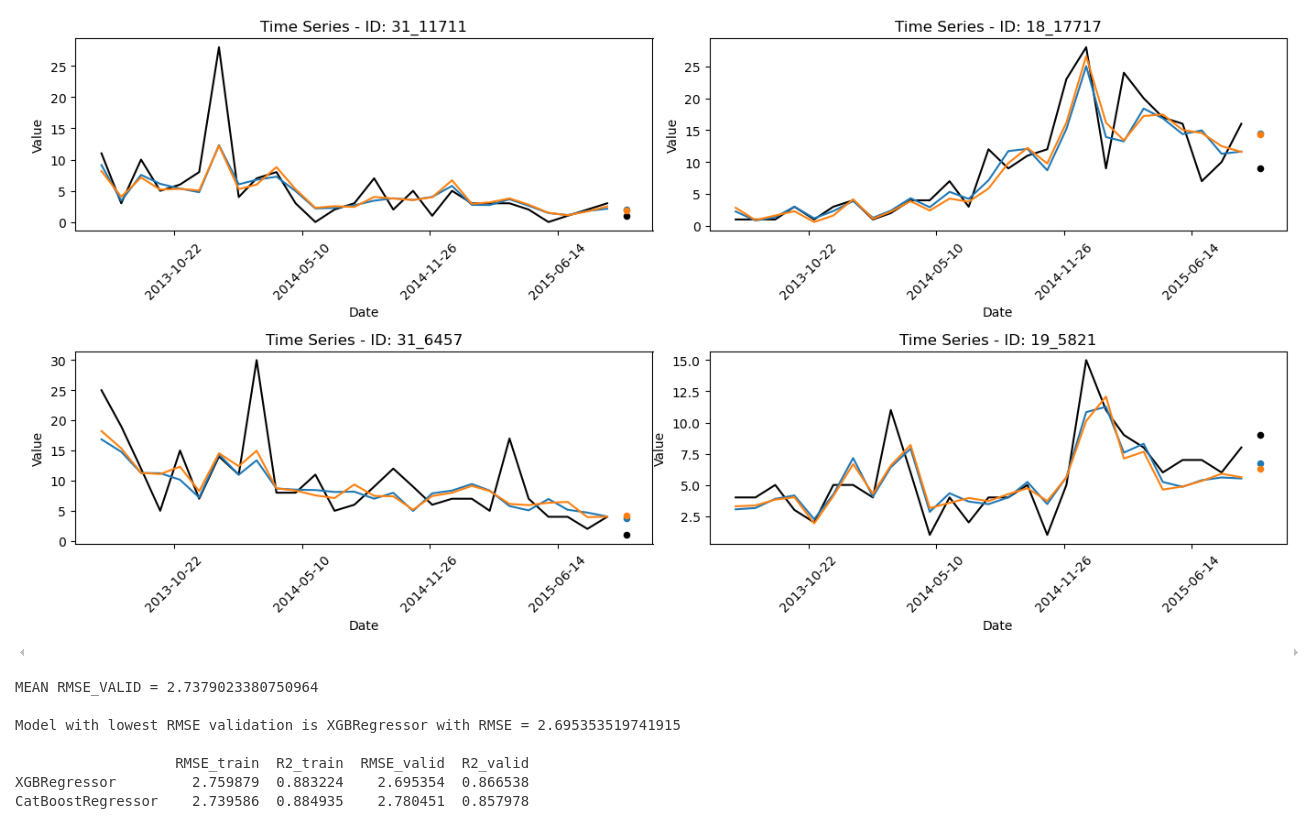
